## Исследование влияния learning rate на качество прогнозирования моделей RNN и LSTM

### Подключение библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Input
from tensorflow.keras.optimizers import Adam

import sys
import os
sys.path.append(os.path.abspath('..'))
from helpful_functions import train_val_test_split, \
                              create_sequences,\
                              denormalize

## 1. Загрузка данных

In [2]:
file_path = '../dataset/preprocessed_data.csv'
df = pd.read_csv(file_path)

df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df.sort_index(inplace=True)

target_feature = 'Global_active_power'
test_ratio = 0.10
val_ratio = 0.10

train_data, val_data, test_data = train_val_test_split(df, val_ratio, test_ratio)

scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

target_idx = df.columns.get_loc(target_feature)

features_count = train_data.shape[1]

## 2. Обучение моделей

In [3]:
learning_rates = [0.1, 0.01, 0.001, 0.0001]
window_sizes = [10, 30, 60, 90, 120]
results = []

for window_size in window_sizes:
    X_train, y_train = create_sequences(train_scaled, target_idx, window_size)
    X_val, y_val = create_sequences(val_scaled, target_idx, window_size)

    for lr in learning_rates:
        print(f"\nTraining RNN | learning_rate = {lr} | window_size = {window_size}")
        
        rnn_model = Sequential([
            Input(shape=(window_size, features_count)),
            SimpleRNN(50, activation='tanh'),
            Dense(1)
        ])
        rnn_model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
        history_rnn = rnn_model.fit(X_train, y_train,
                                    epochs=5,
                                    batch_size=256,
                                    validation_data=(X_val, y_val)) 

        y_pred_rnn = rnn_model.predict(X_val, verbose=0)
        y_pred_rnn_dn = denormalize(scaler, y_pred_rnn, target_feature, df.columns)
        y_true_val_dn = denormalize(scaler, y_val.reshape(-1, 1), target_feature, df.columns)

        mse_rnn = mean_squared_error(y_true_val_dn, y_pred_rnn_dn)

        results.append({
            'model_type': 'RNN',
            'learning_rate': lr,
            'window_size': window_size,
            'train_loss': history_rnn.history['loss'][-1],
            'val_loss': history_rnn.history['val_loss'][-1],
            'mse_dn': mse_rnn
        })

        print(f"RNN | val_loss: {history_rnn.history['val_loss'][-1]:.4f} | MSE: {mse_rnn:.4f}")

        print(f"\nTraining LSTM | learning_rate = {lr} | window_size = {window_size}")

        lstm_model = Sequential([
            Input(shape=(window_size, features_count)),
            LSTM(50, activation='tanh'),
            Dense(1)
        ])
        lstm_model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
        history_lstm = lstm_model.fit(X_train, y_train,
                                      epochs=5,
                                      batch_size=256,
                                      validation_data=(X_val, y_val))

        y_pred_lstm = lstm_model.predict(X_val, verbose=0)
        y_pred_lstm_dn = denormalize(scaler, y_pred_lstm, target_feature, df.columns)

        mse_lstm = mean_squared_error(y_true_val_dn, y_pred_lstm_dn)

        results.append({
            'model_type': 'LSTM',
            'learning_rate': lr,
            'window_size': window_size,
            'train_loss': history_lstm.history['loss'][-1],
            'val_loss': history_lstm.history['val_loss'][-1],
            'mse_dn': mse_lstm
        })

        print(f"LSTM | val_loss: {history_lstm.history['val_loss'][-1]:.4f} | MSE: {mse_lstm:.4f}")


Training RNN | learning_rate = 0.1 | window_size = 10
Epoch 1/5
6486/6486 ━━━━━━━━━━━━━━━━━━━━ 26s 4ms/step - loss: 0.0379 - val_loss: 0.0090
Epoch 2/5
6486/6486 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 0.0322 - val_loss: 0.0073
Epoch 3/5
6486/6486 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.0297 - val_loss: 0.0079
Epoch 4/5
6486/6486 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.0293 - val_loss: 0.0157
Epoch 5/5
6486/6486 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 0.0290 - val_loss: 0.0140
RNN | val_loss: 0.0140 | MSE: 1.7122

Training LSTM | learning_rate = 0.1 | window_size = 10
Epoch 1/5
6486/6486 ━━━━━━━━━━━━━━━━━━━━ 56s 8ms/step - loss: 0.0302 - val_loss: 8.8256e-04
Epoch 2/5
6486/6486 ━━━━━━━━━━━━━━━━━━━━ 54s 8ms/step - loss: 6.2911e-04 - val_loss: 4.0957e-04
Epoch 3/5
6486/6486 ━━━━━━━━━━━━━━━━━━━━ 56s 9ms/step - loss: 6.3501e-04 - val_loss: 0.0010
Epoch 4/5
6486/6486 ━━━━━━━━━━━━━━━━━━━━ 55s 8ms/step - loss: 6.3649e-04 - val_loss: 4.9744e-04
Epoch 5/5
6486/6486 ━━━━━━━━━━━━━━━━

## 3. Сравнение результатов

In [4]:
results_df = pd.DataFrame(results)
print(results_df.sort_values(by=['mse_dn']))

   model_type  learning_rate  window_size  train_loss  val_loss     mse_dn
19       LSTM         0.0100           60    0.000456  0.000336   0.040937
3        LSTM         0.0100           10    0.000466  0.000339   0.041409
11       LSTM         0.0100           30    0.000454  0.000350   0.042765
37       LSTM         0.0010          120    0.000486  0.000354   0.043141
29       LSTM         0.0010           90    0.000493  0.000354   0.043185
27       LSTM         0.0100           90    0.000462  0.000354   0.043238
13       LSTM         0.0010           30    0.000488  0.000358   0.043651
21       LSTM         0.0010           60    0.000494  0.000360   0.043956
28        RNN         0.0010           90    0.000530  0.000367   0.044839
5        LSTM         0.0010           10    0.000503  0.000369   0.045021
20        RNN         0.0010           60    0.000530  0.000369   0.045069
36        RNN         0.0010          120    0.000530  0.000377   0.045944
39       LSTM         0.0

## 4. Нахождение лучших результатов для каждой модели

In [5]:
results_df = pd.DataFrame(results)

best_rnn = results_df[results_df['model_type'] == 'RNN'].nsmallest(1, 'mse_dn').iloc[0]
best_lstm = results_df[results_df['model_type'] == 'LSTM'].nsmallest(1, 'mse_dn').iloc[0]

print("Лучшая RNN:")
print(best_rnn)
print("\nЛучшая LSTM:")
print(best_lstm)

Лучшая RNN:
model_type            RNN
learning_rate       0.001
window_size            90
train_loss        0.00053
val_loss         0.000367
mse_dn           0.044839
Name: 28, dtype: object

Лучшая LSTM:
model_type           LSTM
learning_rate        0.01
window_size            60
train_loss       0.000456
val_loss         0.000336
mse_dn           0.040937
Name: 19, dtype: object


## 5. Заново получаем предсказания этих моделей

In [ ]:
X_train_rnn, y_train_rnn = create_sequences(train_scaled, target_idx, best_rnn['window_size'])
X_val_rnn, y_val_rnn = create_sequences(val_scaled, target_idx, best_rnn['window_size'])

X_train_lstm, y_train_lstm = create_sequences(train_scaled, target_idx, best_lstm['window_size'])
X_val_lstm, y_val_lstm = create_sequences(val_scaled, target_idx, best_lstm['window_size'])

rnn_model = Sequential([
    Input(shape=(best_rnn['window_size'], features_count)),
    SimpleRNN(50, activation='tanh'),
    Dense(1)
])
rnn_model.compile(optimizer=Adam(learning_rate=best_rnn['learning_rate']), loss='mse')
rnn_model.fit(X_train_rnn, y_train_rnn, epochs=5, batch_size=256, validation_data=(X_val_rnn, y_val_rnn), verbose=0)

lstm_model = Sequential([
    Input(shape=(best_lstm['window_size'], features_count)),
    LSTM(50, activation='tanh'),
    Dense(1)
])
lstm_model.compile(optimizer=Adam(learning_rate=best_lstm['learning_rate']), loss='mse')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=256, validation_data=(X_val_lstm, y_val_lstm), verbose=0)

## 6. Делаем предсказания

In [7]:
y_pred_rnn = rnn_model.predict(X_val_rnn, verbose=0)
y_pred_rnn_dn = denormalize(scaler, y_pred_rnn, target_feature, df.columns)
y_true_val_dn = denormalize(scaler, y_val_rnn.reshape(-1, 1), target_feature, df.columns)

y_pred_lstm = lstm_model.predict(X_val_lstm, verbose=0)
y_pred_lstm_dn = denormalize(scaler, y_pred_lstm, target_feature, df.columns)

## 7. Построение графиков моделей на одном window size 

6484/6484 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step
6484/6484 ━━━━━━━━━━━━━━━━━━━━ 32s 5ms/step


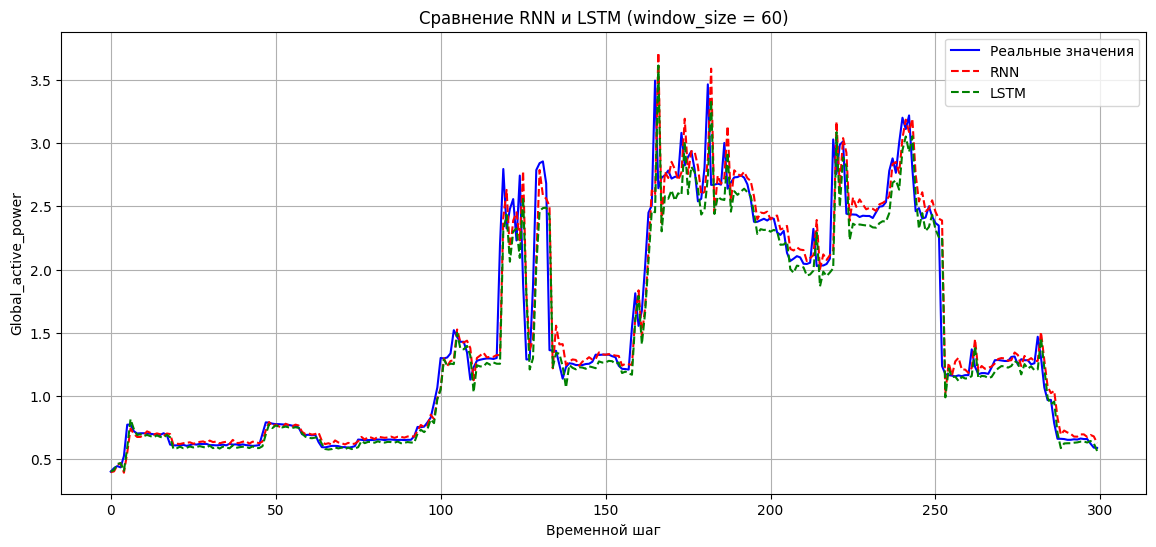

In [20]:
common_window_size = min(best_rnn['window_size'], best_lstm['window_size'])

X_val_common, y_val_common = create_sequences(val_scaled, target_idx, common_window_size)

y_pred_rnn_common = rnn_model.predict(X_val_common)
y_pred_lstm_common = lstm_model.predict(X_val_common)

y_pred_rnn_dn = denormalize(scaler, y_pred_rnn_common, target_feature, df.columns)
y_pred_lstm_dn = denormalize(scaler, y_pred_lstm_common, target_feature, df.columns)
y_true_val_dn = denormalize(scaler, y_val_common.reshape(-1, 1), target_feature, df.columns)

plt.figure(figsize=(14, 6))
plt.plot(y_true_val_dn[:300], label='Реальные значения', color='blue')
plt.plot(y_pred_rnn_dn[:300], label='RNN', color='red', linestyle='--')
plt.plot(y_pred_lstm_dn[:300], label='LSTM', color='green', linestyle='--')

plt.title(f"Сравнение RNN и LSTM (window_size = {common_window_size})")
plt.xlabel("Временной шаг")
plt.ylabel("Global_active_power")
plt.legend()
plt.grid(True)
plt.show()